# Cleaning and EDA

## Data Cleaning

### Read the data

In [1]:
import pandas as pd
import chardet

with open('../Data/data.csv', 'rb') as f:
    result = chardet.detect(f.read())
    print(result['encoding'])

encoding = 'Windows-1252'  

# Read the CSV file with the detected encoding
raw_df = pd.read_csv('../Data/data.csv', encoding=encoding, header=0)  

# Set column name as 'sentiment' and 'raw_comm'
raw_df.columns = ['sentiment', 'raw_comm']

print(raw_df.head())

Windows-1252
  sentiment                                           raw_comm
0   neutral  Technopolis plans to develop in stages an area...
1  negative  The international electronic industry company ...
2  positive  With the new production plant the company woul...
3  positive  According to the company 's updated strategy f...
4  positive  FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


### Create a comment column with only nouns

In [4]:
import spacy

# Combine all comments into a single string
text = " ".join(raw_df['raw_comm'])

# Load the English language model
nlp = spacy.load('en_core_web_sm')

# Function to extract nouns from a comment
def extract_nouns(text):
    doc = nlp(text)
    nouns = [token.text for token in doc if token.pos_ == 'NOUN']
    return " ".join(nouns)

# Apply the function to each comment
raw_df['nouns_comm'] = raw_df['raw_comm'].apply(extract_nouns)

# Display the DataFrame with extracted nouns
print(raw_df.head())

# Save this new df to a new CSV file
raw_df.to_csv('Data/clean_data.csv', index=False)

ModuleNotFoundError: No module named 'spacy'

## EDA

### Sentiment count distribution

utf-8


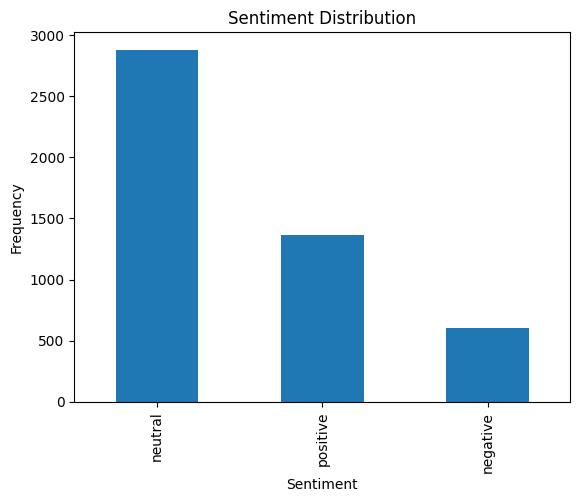

In [11]:
import pandas as pd
import chardet
import matplotlib.pyplot as plt

with open('Data/clean_data.csv', 'rb') as f:
    result = chardet.detect(f.read())
    print(result['encoding'])

encoding = 'Windows-1252'  

# Read the CSV file with the detected encoding
df = pd.read_csv('Data/clean_data.csv', encoding=encoding, header=0) 

# Plot the sentiment distribution
sentiment_count = df['sentiment'].value_counts()
sentiment_count.plot(kind = 'bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

### Wordcloud for all sentiment

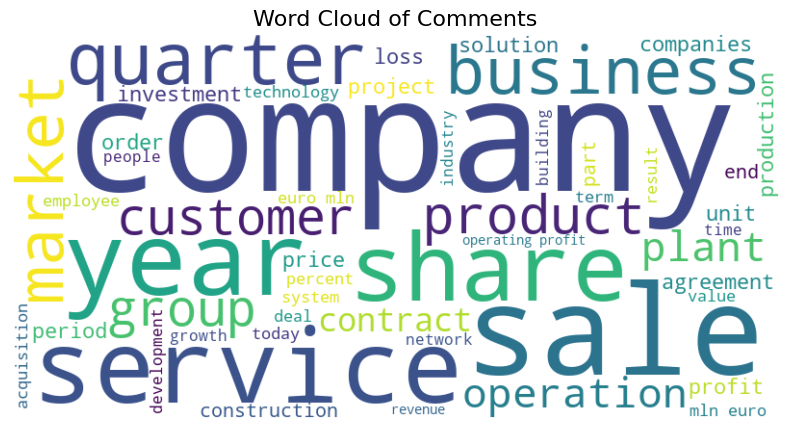

In [12]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Custom stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['will', 'mn', 'm']) 

# Create a word cloud object
wordcloud = WordCloud(
    width=800,                # Width of the canvas
    height=400,               # Height of the canvas
    background_color='white', # Background color of the word cloud
    max_words=50,            # Maximum number of words to display
    contour_color='steelblue',# Color of the contour
    contour_width=1,          # Width of the contour line
    colormap='viridis',       # Color map for the words
    stopwords=custom_stopwords            # Stopwords to exclude (default is None)
).generate(df['nouns_comm'].str.cat(sep=' '))  # Concatenate all nouns into a single string

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis lines and labels
plt.title('Word Cloud of Comments', fontsize=16)
plt.show()


### Wordclourd per sentiment

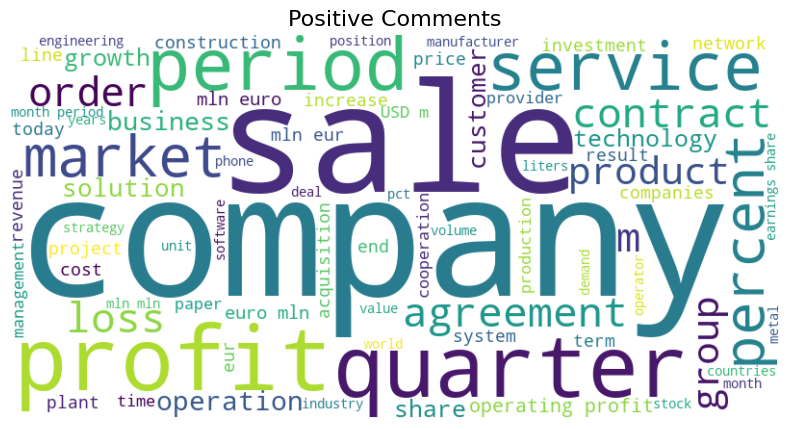

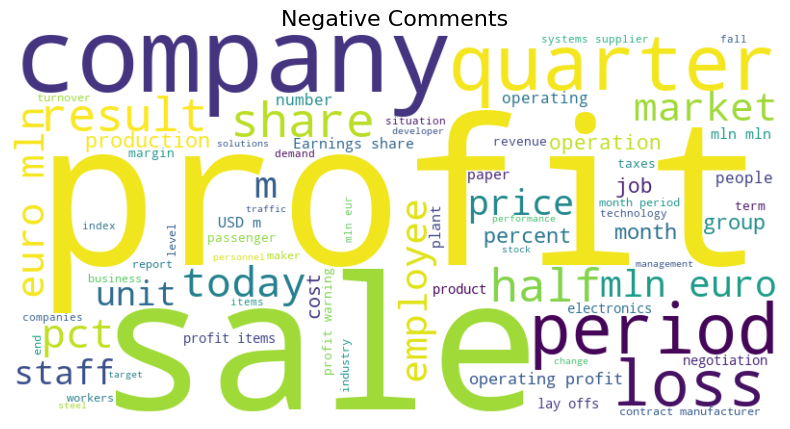

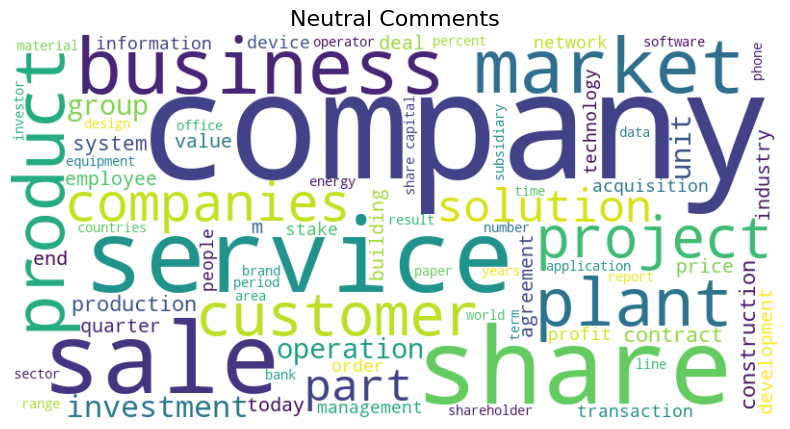

In [13]:
from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(text, title):
    # Custom stopwords
    custom_stopwords = set(STOPWORDS)
    custom_stopwords.update(['will', 'mn', 'mln,' 'Company', 'Finnish', 'year']) 

    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=75, stopwords=custom_stopwords).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Fill NaN values in the 'nouns' column with an empty string
df['nouns_comm'] = df['nouns_comm'].fillna('')

positive_text = " ".join(df[df['sentiment'] == 'positive']['nouns_comm'])
negative_text = " ".join(df[df['sentiment'] == 'negative']['nouns_comm'])
neutral_text = " ".join(df[df['sentiment'] == 'neutral']['nouns_comm'])

plot_wordcloud(positive_text, 'Positive Comments')
plot_wordcloud(negative_text, 'Negative Comments')
plot_wordcloud(neutral_text, 'Neutral Comments')


### Text length distribution per sentiment

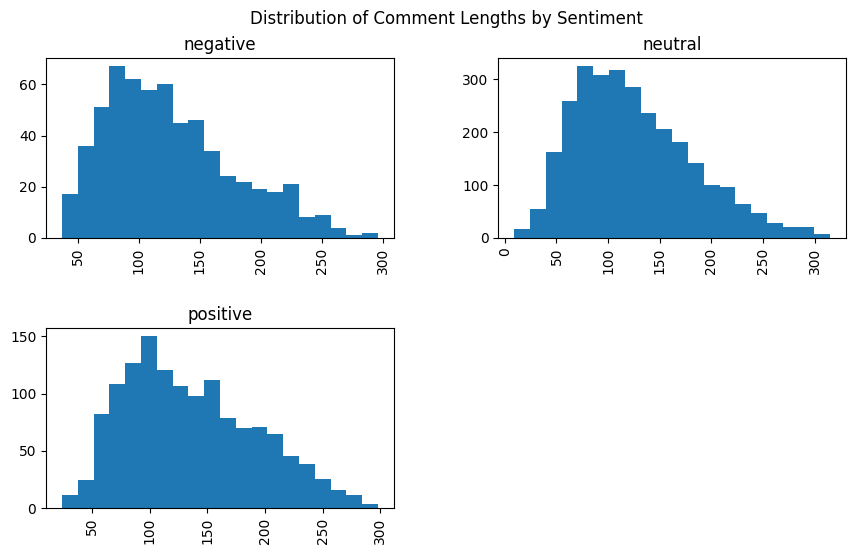

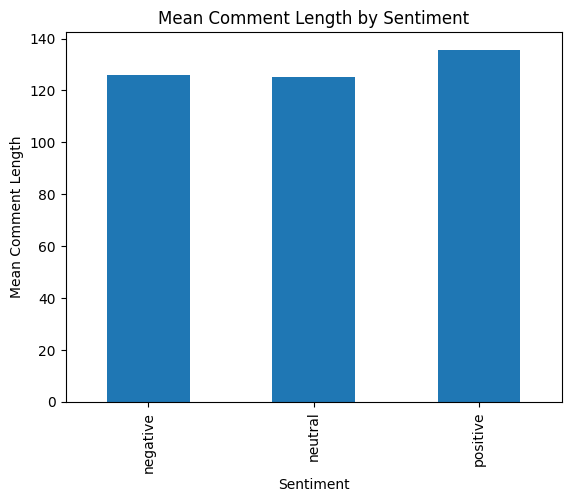

sentiment
negative    125.781457
neutral     125.101112
positive    135.667645
Name: comment_length, dtype: float64


In [14]:
df['comment_length'] = df['raw_comm'].apply(len)

df.hist(column='comment_length', by='sentiment', bins=20, figsize=(10, 6))
plt.suptitle('Distribution of Comment Lengths by Sentiment')
plt.show()

# Comment length mean by sentiment
mean_length = df.groupby('sentiment')['comment_length'].mean()

mean_length.plot(kind='bar')
plt.title('Mean Comment Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Mean Comment Length')
plt.show()

print(mean_length)

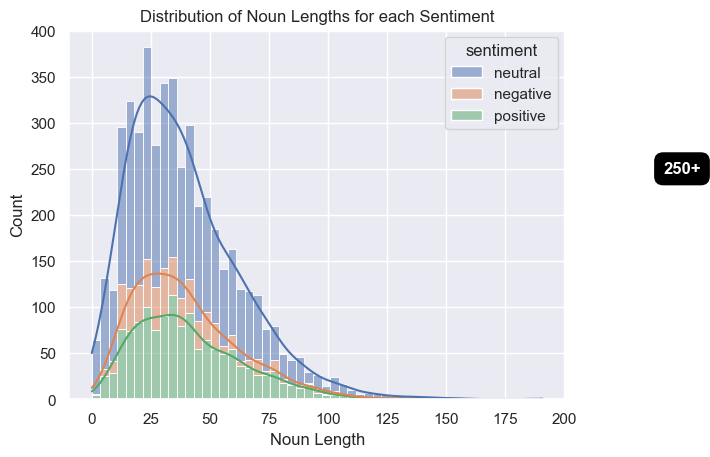

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Fill NaN values in the 'nouns' column with an empty string
df['nouns_comm'] = df['nouns_comm'].fillna('')

# Calculate the length of the noun phrases
df['nouns_length'] = df['nouns_comm'].apply(len)

# Set the style of the plot
sns.set(style="darkgrid")

# Filter the noun lengths less than or equal to 250
filtered_df = df[df['nouns_length'] <= 250]

# Plot the distribution of noun lengths for each sentiment
sns.histplot(data=filtered_df, x="nouns_length", hue="sentiment", multiple="stack", kde=True)

# Set the title and labels
plt.title("Distribution of Noun Lengths for each Sentiment")
plt.xlabel("Noun Length")
plt.ylabel("Count")

# Add a label for noun lengths greater than 250
plt.text(250, 250, '250+', ha='center', va='center', color='white', fontweight='bold', fontsize=12,
         bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.5'))

# Show the plot
plt.show()


### Most common words per sentiment

Top 10 words in positive comments: [('sales', 191), ('profit', 191), ('period', 139), ('quarter', 114), ('loss', 72), ('percent', 68), ('share', 66), ('market', 66), ('today', 60), ('services', 60)]
Top 10 words in negative comments: [('profit', 156), ('sales', 98), ('period', 90), ('quarter', 89), ('loss', 69), ('today', 33), ('half', 33), ('share', 32), ('operating', 29), ('result', 29)]
Top 10 words in neutral comments: [('business', 164), ('shares', 162), ('sales', 160), ('share', 136), ('market', 126), ('services', 126), ('production', 87), ('value', 81), ('companies', 80), ('group', 80)]


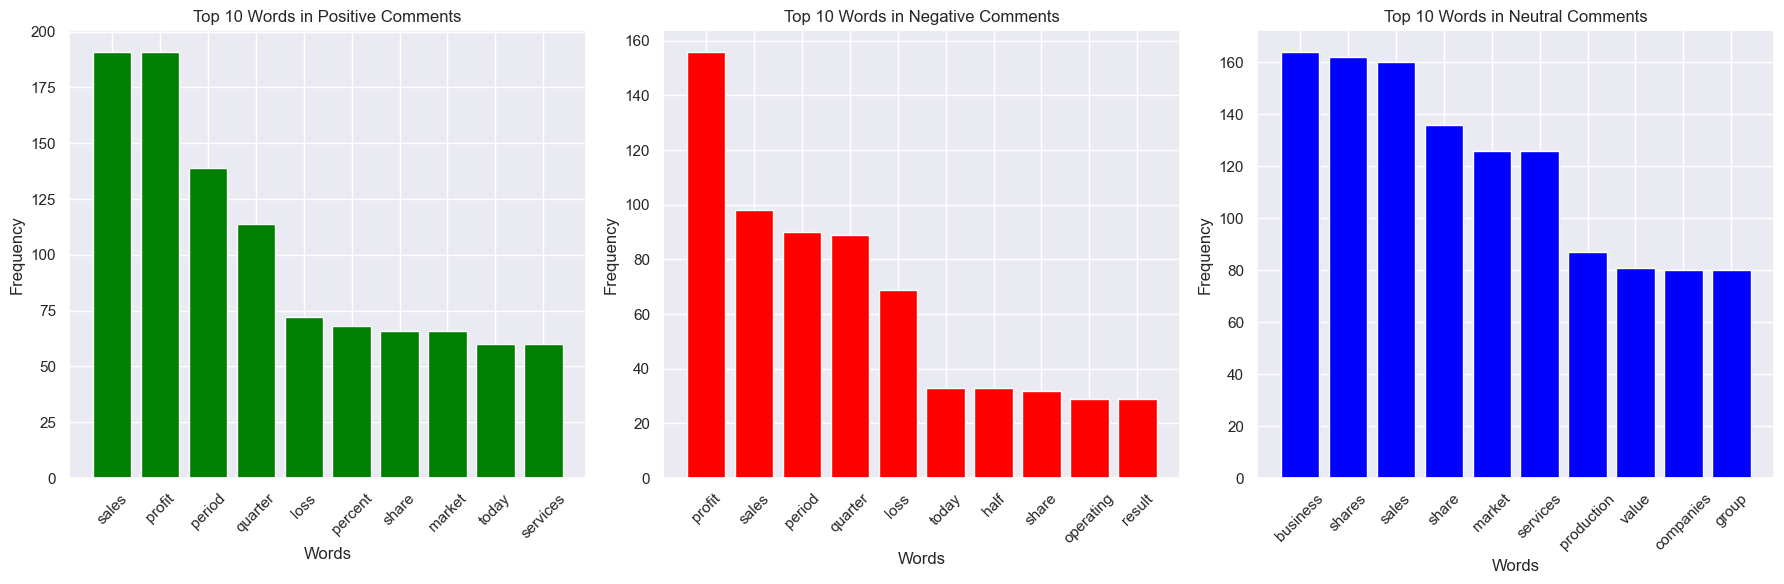

In [16]:
from collections import Counter
import re

def get_top_n_words(corpus, n=10, stopwords=None):
    if stopwords is None:
        stopwords = set()
    words = re.findall(r'\w+', corpus.lower())
    filtered_words = [word for word in words if word not in stopwords]
    return Counter(filtered_words).most_common(n)

# Define custom stopwords
custom_stopwords = {'mn', 'mln', 'will','m', 's', 'eur', 'pct', 'company', 'said', 'finnish', 'year'}

# Get top words while excluding stopwords
positive_words = get_top_n_words(positive_text, 10, stopwords=custom_stopwords)
negative_words = get_top_n_words(negative_text, 10, stopwords=custom_stopwords)
neutral_words = get_top_n_words(neutral_text, 10, stopwords=custom_stopwords)

print('Top 10 words in positive comments:', positive_words)
print('Top 10 words in negative comments:', negative_words)
print('Top 10 words in neutral comments:', neutral_words)

# Plotting the top words for each sentiment as subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot for positive sentiment
positive_words_dict = dict(positive_words)
axs[0].bar(positive_words_dict.keys(), positive_words_dict.values(), color='green')
axs[0].set_title('Top 10 Words in Positive Comments')
axs[0].set_xlabel('Words')
axs[0].set_ylabel('Frequency')
axs[0].tick_params(axis='x', rotation=45)

# Plot for negative sentiment
negative_words_dict = dict(negative_words)
axs[1].bar(negative_words_dict.keys(), negative_words_dict.values(), color='red')
axs[1].set_title('Top 10 Words in Negative Comments')
axs[1].set_xlabel('Words')
axs[1].set_ylabel('Frequency')
axs[1].tick_params(axis='x', rotation=45)

# Plot for neutral sentiment
neutral_words_dict = dict(neutral_words)
axs[2].bar(neutral_words_dict.keys(), neutral_words_dict.values(), color='blue')
axs[2].set_title('Top 10 Words in Neutral Comments')
axs[2].set_xlabel('Words')
axs[2].set_ylabel('Frequency')
axs[2].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Function to get top n-grams
def get_top_n_ngrams(corpus, n=10, ngram_range=(2, 2), stopwords=None):
    if stopwords is None:
        stopwords = []
    
    # Convert stopwords to a list if it's a set
    stopwords = list(stopwords)
    
    vec = CountVectorizer(ngram_range=ngram_range, stop_words=stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    return words_freq[:n]

# Define custom stopwords
custom_stopwords = ['mn', 'mln', 'will', 'm', 's', 'eur', 'pct', 'company', 'said', 'finnish', 'year']

# Get top bigrams while excluding custom stopwords
positive_bigrams = get_top_n_ngrams(df[df['sentiment'] == 'positive']['nouns_comm'], 10, (2, 2), stopwords=custom_stopwords)
negative_bigrams = get_top_n_ngrams(df[df['sentiment'] == 'negative']['nouns_comm'], 10, (2, 2), stopwords=custom_stopwords)
neutral_bigrams = get_top_n_ngrams(df[df['sentiment'] == 'neutral']['nouns_comm'], 10, (2, 2), stopwords=custom_stopwords)

# Print the results
print('Top 10 bigrams in positive comments:', positive_bigrams)
print('Top 10 bigrams in negative comments:', negative_bigrams)
print('Top 10 bigrams in neutral comments:', neutral_bigrams)


Top 10 bigrams in positive comments: [('operating profit', 40), ('profit period', 25), ('month period', 20), ('earnings share', 19), ('profit sales', 16), ('loss period', 15), ('today profit', 15), ('market share', 14), ('profit loss', 13), ('profit quarter', 13)]
Top 10 bigrams in negative comments: [('loss profit', 22), ('profit quarter', 22), ('profit period', 15), ('operating profit', 15), ('earnings share', 12), ('lay offs', 11), ('profit items', 11), ('sales quarter', 10), ('profit warning', 10), ('profit euro', 10)]
Top 10 bigrams in neutral comments: [('share capital', 37), ('voting rights', 26), ('number shares', 16), ('total shares', 13), ('shares share', 13), ('market analysis', 13), ('market share', 12), ('stock option', 11), ('business operations', 11), ('board directors', 11)]
